In [43]:
import praw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')

# Put in your own credentials to use praw.
reddit = praw.Reddit(client_id = 'client_id',
                     client_secret = 'client_secret',
                     username = 'username',
                     password = 'password',
                     user_agent = 'user_agent')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\johns\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\johns\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\johns\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johns\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Getting data using the Reddit API and putting it into a Data Frame

Here we gather a sample of comments from r/democrats and r/republicans subreddits to train the model. Numbers are appended to the political orientation list to categorize each comment as being Democrat(0) or Republican(1). Then we clean the data. 

In [ ]:
# Make lists holding each comment and political orientation 0 for democrat and 1 for republican.
comments = []
political_orientation = []

for comment in reddit.subreddit('democrats').comments(limit = None):
    comments.append(comment.body)
    political_orientation.append(0)
    
    

for comment in reddit.subreddit('republicans').comments(limit = None):
    comments.append(comment.body)
    political_orientation.append(1)

# Put lists into a DataFrame.
data = {'Comment': comments,'Political Orientation':political_orientation}
df = pd.DataFrame.from_dict(data, orient='index')
df = df.transpose()

In [ ]:
def standardize_text(df, text_field):
    """Function to remove unnecessary characters and puncuation from text."""
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df
df = standardize_text(df, "Comment")

Here we save the data to an csv file and use that from now on so we don't have to re_scrape the data everytime something is changed.

In [ ]:
# Save new Data Frame to csv file.

df.to_csv("political_comments.csv")

In [3]:
df = pd.read_csv("political_comments.csv")

df.head()

,Unnamed: 0,Comment,Political Orientation
0,0,say it's not true that trump lied again that m...,0
1,1,"right up there with trump defending his ""size""...",0
2,2,he lies about everything of course there we...,0
3,3,your submission has been automatically removed...,0
4,4,cue incoming presidential rant about how nort...,0


### Further Preprocessing

Much of the data is found to contain a bot warning letting people in the subreddit know that it is a repulican subreddit only. Leaving this in would defintely interfere in our training so we are going to take this out of the data.

In [4]:
# Filter out comments containing "\n"please note that this is a republican.."
df.dropna(inplace=True) 
    
len(df[df['Comment'].str.contains('\n"please note that this is')])

df = df[~df['Comment'].str.contains('\n"please note that this is')]

# Choosing The Best Way to Encode Our Comments

Removing stop words and lemmatization strategies were carried out but they did not give out any relevant results so we are going to use a count vectorizer on the data which tokenizes the data, and adds a bag of words model to the tokens, turning them into a series of numbers for the algorithms to interpret.

Then we will use a TF-IDF vectorizer on top of the bag of words model to account to help remove irrelevant words that may just account for noise in the dataset. 

We will feed these into a Logistic Regression model and compare the results.


In [5]:
def cv(data):
    """Function to use the count vectorizer (bag of words model) to transform the comments."""
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

# Put data into X and y variables.
X = df["Comment"] 
y = df["Political Orientation"]

# Split the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

Here we visualize our model and the distinction between Democrat and Republican comments.

The ideal situation is to see a good amount of seperation between variables, but we don't exactly see that here.

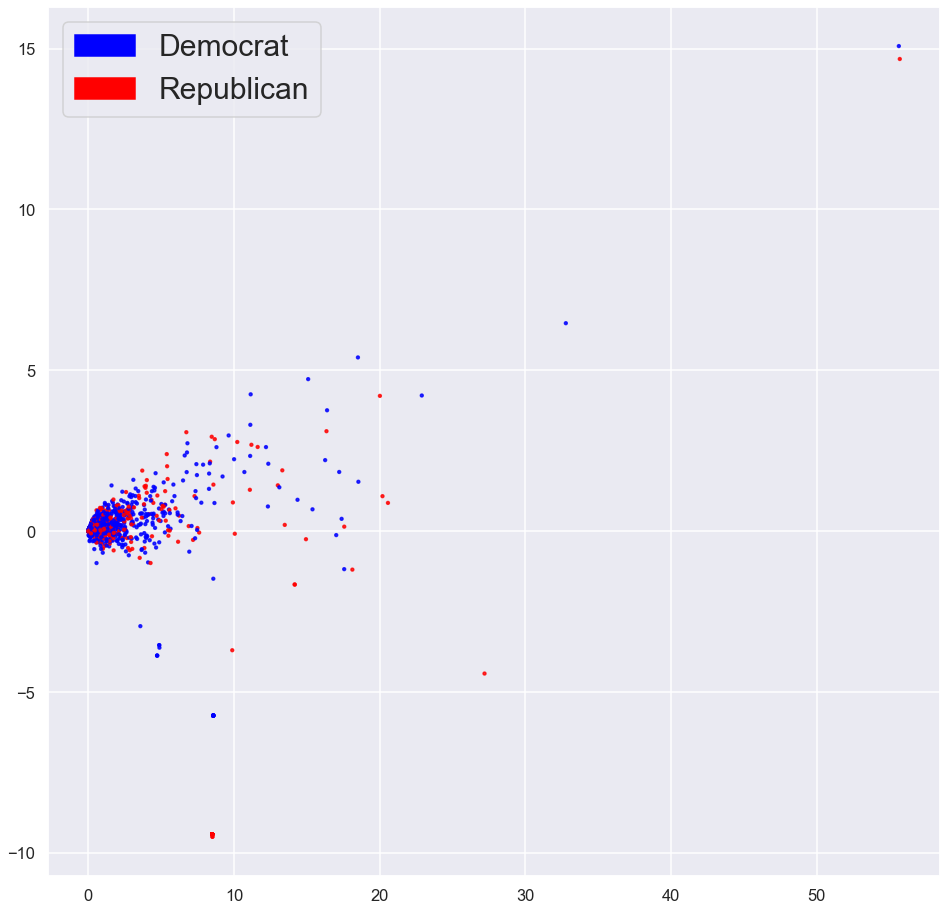

In [61]:
def plot_LSA(test_data, test_labels, plot=True):
        """Function to set graph components and create template to input data."""
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['blue','red','red']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='blue', label='Democrat')
            green_patch = mpatches.Patch(color='red', label='Republican')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [62]:
# Put in hyper parameters, fit the model, and get predictions.
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [63]:
def get_metrics(y_test, y_predicted):
    """Function to do the math to get test scores for precision, recall, and f1 scores."""
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.692, precision = 0.693, recall = 0.692, f1 = 0.692


# Analyse The Model

First we use a confusion matrix and then make a graph to see the most important words used in the model.

Here we see 122 True positives, and 42 True negatives.

In [64]:
confusion_matrix(y_test, y_predicted_counts)

array([[122,  37],
       [ 36,  42]], dtype=int64)

To create the graph we first need to get the most important features by taking all the words in the comments and assigning them to top and bottoms of importance, then we plot the graph.

In [65]:
def get_most_important_features(vectorizer, model, n=5):
    """Function to get the most important words by sorting by coefficients into tops and bottoms."""
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

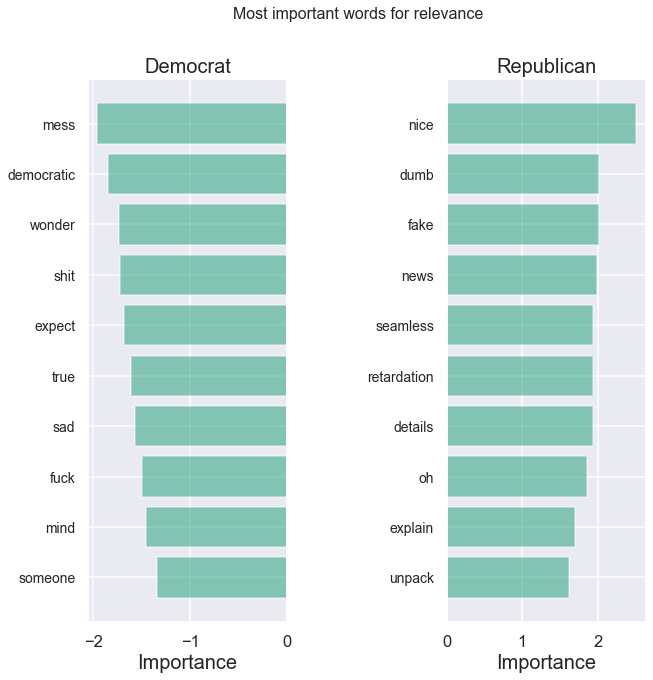

In [66]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    """ Designing the graph to plot most important top and bottom words with their scores."""
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Democrat', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Republican', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

## TF-IDF vectorizer

We use a TF-IDF vectorizer on top of the bag of words model. This model will help disregard very common words that may be in the data set that just would just add to unecessary noise. For example "The" or "It".

In [67]:
def tfidf(data):
    """Function to apply vectorizer"""
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

We graph the results again and here we see a better separation. Still not good, but better.

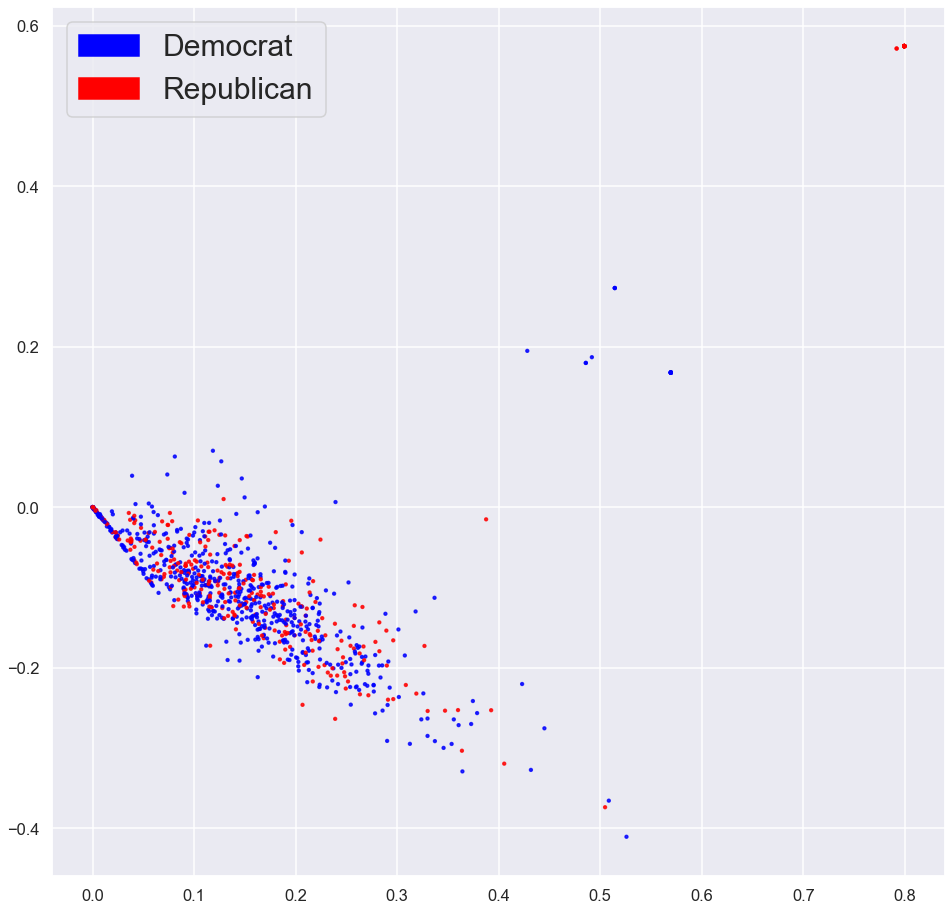

In [68]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

We apply the model again and this time we have better results. Now at an accuracy of %73.8!

We also see improvements in our confusion matrix.

In [33]:
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)


clf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf.predict(X_test_tfidf)


accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.738, precision = 0.735, recall = 0.738, f1 = 0.737


In [34]:
confusion_matrix(y_test, y_predicted_tfidf)

array([[130,  29],
       [ 33,  45]], dtype=int64)

In [35]:
importance = get_most_important_features(tfidf_vectorizer, clf, 10)

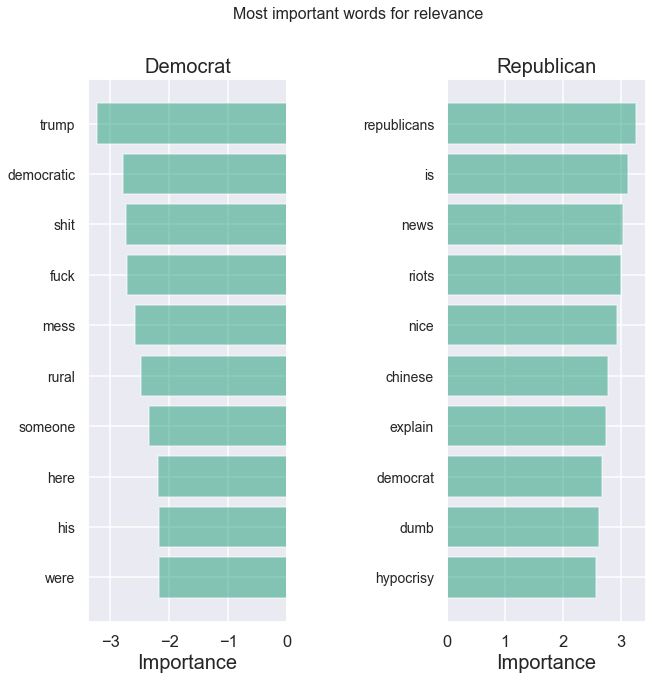

In [36]:
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# Choosing The Best Model

Lastly, we going to try out 2 more sklearn models to see if we get better results using a Naive Bayes model and a Support Vector Machine Classifier. Paremeters were tweaked in all models largely using a grid search to aid in finding best results.


Because the TF-IDF vectorizer faired better than the count vectorizer, we will be using that from now on. 

### Naive Bayes

Our Naive Bayes model gave us worse results than the logistic regression so we will scrap this one.

In [40]:
# Fitting GaussianNB model to the dataset.
# todense() is needed to turn training data to a numpy array for the GaussianNB model to process.
gnb = GaussianNB()

gnb.fit(X_train_tfidf.todense(), y_train)

y_predicted_tfidf = gnb.predict(X_test_tfidf.todense())

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.654, precision = 0.688, recall = 0.654, f1 = 0.663


### Support Vector Machine

One thing to note, according to the confusion matrix, there were many false negatives and barely any false positives in this model. Meaning it may be more inclined to predict a democrat when it is actually a republican comment much more than the opposite error.

In [53]:
clf = svm.SVC(C = 40, gamma = .02, kernel= 'sigmoid', random_state=40)

clf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf.predict(X_test_tfidf)

In [54]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.755, precision = 0.768, recall = 0.755, f1 = 0.720


In [55]:
confusion_matrix(y_test, y_predicted_tfidf)

array([[153,   6],
       [ 52,  26]], dtype=int64)

# Conclusion

It may be hard to say wether it is best to choose the Logistic Regression or the Support Vector Classifier model. With Logistic Regression, you get an almost equal amount of false positives and false negatives while the latter has a little better accuracy on the test data, but has many false negatives. 

This model could definitely be improved. There are probably many unthought of ways to get better results. It would be great to see some professional data scientists take a crack at it. 
